
# **Libraries Handling**


In [24]:
!pip install pm4py

In [25]:
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils

# **Loading, cleaning and filtering**

Data Loading, Preprocessing, and Attribute Enrichment

In [26]:
file_path = 'dataset_for_exam.csv'
df = pd.read_csv(file_path)

# Remove duplicates
df.drop_duplicates(inplace=True)
print(f"Original Dataset Size: {len(df)} rows")

# Rename columns for PM4Py compliance
df.rename(columns={
    'stay_id': 'case:concept:name',
    'activity': 'concept:name',
    'time': 'time:timestamp'
}, inplace=True)

# Convert timestamp
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])
df['case:concept:name'] = df['case:concept:name'].astype(str)

# Sort by case and time
df = df.sort_values(by=['case:concept:name', 'time:timestamp'])

# Merge nurse columns into a single resource column
if 'administering_nurse_id' in df.columns and 'reconciliation_nurse_id' in df.columns:
    df['org:resource'] = df['administering_nurse_id'].combine_first(df['reconciliation_nurse_id'])
    df['org:resource'] = df['org:resource'].fillna('Unknown')

# Propagate Acuity and Disposition values to all rows in the case
if 'acuity' in df.columns:
    # Convert to numeric
    df['acuity'] = pd.to_numeric(df['acuity'], errors='coerce')
    # Fill missing values using forward and backward fill
    df['acuity'] = df.groupby('case:concept:name')['acuity'].transform(lambda x: x.ffill().bfill())

if 'disposition' in df.columns:
    # Fill missing values using forward and backward fill
    df['disposition'] = df.groupby('case:concept:name')['disposition'].transform(lambda x: x.ffill().bfill())

print(f"Dataset ready for Cleaning: {len(df)} rows.")

Original Dataset Size: 25115 rows
Dataset ready for Cleaning: 25115 rows.


Data Cleaning and Vital Signs Filtering

In [27]:
# Remove events missing Case ID, Timestamp, or Activity
initial_len = len(df)
initial_cases = df['case:concept:name'].nunique()
df.dropna(subset=['case:concept:name', 'time:timestamp', 'concept:name'], inplace=True)
df.drop_duplicates(subset=['case:concept:name', 'time:timestamp', 'concept:name'], keep='first', inplace=True)

print(f"Rows removed (missing or duplicates): {initial_len - len(df)}")

# Clean numerical attributes (Vital Signs) for future use
# Convert to numeric, forcing errors to NaN
vital_signs = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']
for col in vital_signs:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 1. Temperature
if 'temperature' in df.columns:
    initial_rows = len(df)
    mask_temp = df['temperature'].isna() | ((df['temperature'] > 90) & (df['temperature'] < 110))
    df = df[mask_temp]
    print(f"Rows removed due to invalid temperature: {initial_rows - len(df)}")

# 2. Heart Rate
if 'heartrate' in df.columns:
    initial_rows = len(df)
    mask_hr = df['heartrate'].isna() | ((df['heartrate'] >= 30) & (df['heartrate'] <= 250))
    df = df[mask_hr]
    print(f"Rows removed due to invalid heart rate: {initial_rows - len(df)}")

# 3. Respiratory Rate
if 'resprate' in df.columns:
    initial_rows = len(df)
    mask_rr = df['resprate'].isna() | ((df['resprate'] >= 5) & (df['resprate'] <= 60))
    df = df[mask_rr]
    print(f"Rows removed due to invalid respiratory rate: {initial_rows - len(df)}")

# 4. Oxygen Saturation
if 'o2sat' in df.columns:
    initial_rows = len(df)
    mask_o2 = df['o2sat'].isna() | ((df['o2sat'] >= 50) & (df['o2sat'] <= 100))
    df = df[mask_o2]
    print(f"Rows removed due to invalid oxygen saturation: {initial_rows - len(df)}")

# 5. Blood Pressure
if 'sbp' in df.columns and 'dbp' in df.columns:
    initial_rows = len(df)
    mask_bp = (
        (df['sbp'].isna() & df['dbp'].isna()) |
        (
            (df['sbp'] >= 50) & (df['sbp'] <= 250) &
            (df['dbp'] >= 30) & (df['dbp'] <= 150) &
            (df['sbp'] > df['dbp'])
        )
    )
    df = df[mask_bp]
    print(f"Rows removed due to invalid blood pressure: {initial_rows - len(df)}")

Rows removed (missing or duplicates): 8289
Rows removed due to invalid temperature: 7
Rows removed due to invalid heart rate: 7
Rows removed due to invalid respiratory rate: 1
Rows removed due to invalid oxygen saturation: 2
Rows removed due to invalid blood pressure: 25


Filtering for Complete Traces

In [28]:
# Convert 'case:concept:name' to string type as required by PM4Py
df['case:concept:name'] = df['case:concept:name'].astype(str)

# Define expected activities
start_activities = ['Enter the ED']
end_activities = ['Discharge from the ED'] # Add other end activities here if present

# 1. Start filter: must begin with entry
df = pm4py.filter_start_activities(df, start_activities)

# 2. End filter: must finish with a formal outcome
# Applying to the previously filtered df ensures correct start and end
df = pm4py.filter_end_activities(df, end_activities)

# Check remaining cases
print(f"Complete cases count (started and ended correctly): {df['case:concept:name'].nunique()}")

Complete cases count (started and ended correctly): 1820


Statistical Duration Filtering and Outlier Removal

In [29]:
# Calculate total duration for each case
# Group by ID and calculate difference between start and end
case_durations = df.groupby('case:concept:name')['time:timestamp'].agg(['min', 'max'])
case_durations['duration_sec'] = (case_durations['max'] - case_durations['min']).dt.total_seconds()

# Define statistical thresholds
# Minimum threshold 60 seconds to exclude system errors
min_threshold = 60

# Maximum threshold using 99th percentile
# Remove top 1% outliers representing open zombie cases
max_threshold = case_durations['duration_sec'].quantile(0.99)

print(f"Minimum time threshold: {min_threshold} sec")
print(f"Maximum time threshold (99th percentile): {max_threshold} sec")

# Identify valid cases within thresholds
valid_cases_time = case_durations[
    (case_durations['duration_sec'] >= min_threshold) &
    (case_durations['duration_sec'] <= max_threshold)
].index

# Filter the original dataset
n_cases_pre = df['case:concept:name'].nunique()
df = df[df['case:concept:name'].isin(valid_cases_time)]
n_cases_post = df['case:concept:name'].nunique()

print(f"Cases removed due to anomalous duration: {n_cases_pre - n_cases_post}")
print(f"Valid cases remaining: {n_cases_post}")

Minimum time threshold: 60 sec
Maximum time threshold (99th percentile): 116731.79999999996 sec
Cases removed due to anomalous duration: 19
Valid cases remaining: 1801


Variant Analysis and Pareto Based Filtering

In [30]:
# Get variants
# variants_dict is either variant count or variant case list
variants_dict = pm4py.get_variants(df)

# Determine total number of cases meaning patients not events
total_cases = df['case:concept:name'].nunique()
print(f"Total unique cases: {total_cases}")

# Normalize dictionary for sorting
# Create a list of tuples with variant and case count
# This step resolves the TypeError
variants_counts = []
for var, val in variants_dict.items():
    # If val is a list take its length otherwise use integer value
    count = len(val) if isinstance(val, list) else val
    variants_counts.append((var, count))

# Sort from most frequent to least frequent variant
sorted_variants = sorted(variants_counts, key=lambda x: x[1], reverse=True)

print(f"Distinct variants found: {len(sorted_variants)}")

# Filter function
def get_top_variants_by_coverage(sorted_vars_list, total, coverage_target):
    current_sum = 0
    kept_variants = []
    for variant, count in sorted_vars_list:
        kept_variants.append(variant)
        current_sum += count
        # Calculate accumulated coverage
        if (current_sum / total) >= coverage_target:
            break
    return kept_variants

# Define lists with 80 percent and 99 percent cutoffs
# Logic is 80 percent of patients follow standard paths while 99 percent includes almost everything except errors
vars_80 = get_top_variants_by_coverage(sorted_variants, total_cases, 0.80)
vars_99 = get_top_variants_by_coverage(sorted_variants, total_cases, 0.99)

# Apply filters
# filter_variants accepts the list of variant keys
df_discovery = pm4py.filter_variants(df, vars_80)
df_clean = pm4py.filter_variants(df, vars_99)

# Reporting
n_post_disc = df_discovery['case:concept:name'].nunique()
n_post_clean = df_clean['case:concept:name'].nunique()

print(f"\nDataset Discovery (Target 80%):")
print(f"Kept variants: {len(vars_80)}")
print(f"Kept cases: {n_post_disc} (out of {total_cases})")

print(f"\nDataset Analysis (Target 99%):")
print(f"Kept variants: {len(vars_99)}")
print(f"Kept cases: {n_post_clean} (out of {total_cases})")
print(f"Removed cases (Noise): {total_cases - n_post_clean}")

# Final assignment
# Use the 99 percent cleaned dataset for analysis
if n_post_clean > 0:
    df = df_clean.copy()
else:
    print("ERROR: The filter removed everything. Keeping original dataset.")

# Sort for safety
df = df.sort_values(by=['case:concept:name', 'time:timestamp'])

Total unique cases: 1801
Distinct variants found: 880

Dataset Discovery (Target 80%):
Kept variants: 520
Kept cases: 1441 (out of 1801)

Dataset Analysis (Target 99%):
Kept variants: 862
Kept cases: 1783 (out of 1801)
Removed cases (Noise): 18


# **Performance analysis**

Performance Metrics Calculation

In [31]:
# Graphic Configuration
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Sort by case and time
df = df.sort_values(by=['case:concept:name', 'time:timestamp'])

# Lead Time Calculation (Total Stay Duration)
# Group by case and calculate End minus Start in Days
df['case_start'] = df.groupby('case:concept:name')['time:timestamp'].transform('min')
df['case_end'] = df.groupby('case:concept:name')['time:timestamp'].transform('max')
df['lead_time_days'] = (df['case_end'] - df['case_start']).dt.total_seconds() / (24 * 3600)

# Waiting Time Calculation (Time between activities)
# Difference from the previous row of the same case in Hours
df['prev_time'] = df.groupby('case:concept:name')['time:timestamp'].shift(1)
df['step_duration_hours'] = (df['time:timestamp'] - df['prev_time']).dt.total_seconds() / 3600
df['step_duration_hours'] = df['step_duration_hours'].fillna(0)

Lead Time Analysis and Visualization


LEAD TIME BY ACUITY LEVEL
        count      mean       std       min       25%       50%       75%  \
acuity                                                                      
1.0     126.0  0.239565  0.178990  0.006250  0.136806  0.190625  0.279167   
2.0     590.0  0.322870  0.238557  0.023611  0.166742  0.251042  0.383785   
3.0     863.0  0.250195  0.191000  0.002778  0.134722  0.201389  0.302778   
4.0     142.0  0.125954  0.077536  0.010417  0.075174  0.118750  0.152778   
5.0       7.0  0.112996  0.127737  0.026389  0.036458  0.061111  0.121181   

             max  
acuity            
1.0     0.919444  
2.0     1.343750  
3.0     1.211806  
4.0     0.572222  
5.0     0.388194  


/tmp/ipython-input-1143156793.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=case_df, x='acuity', y='lead_time_days', palette='coolwarm')


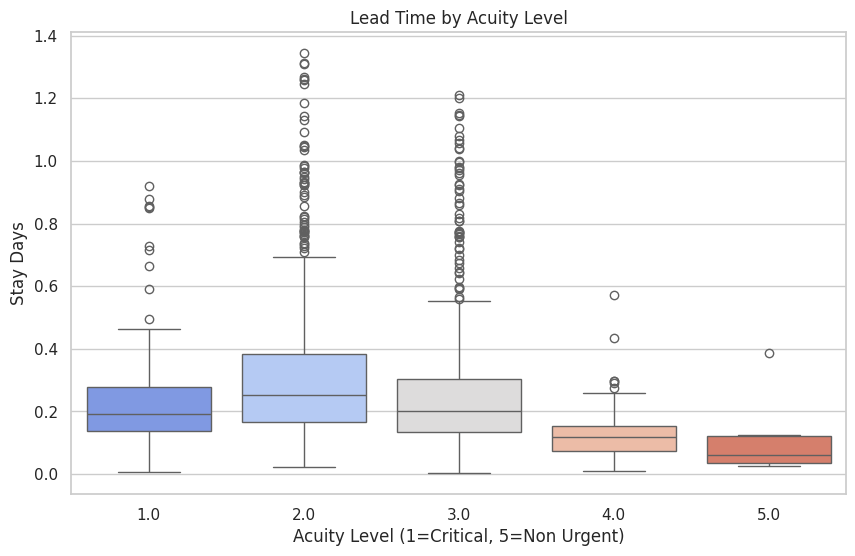

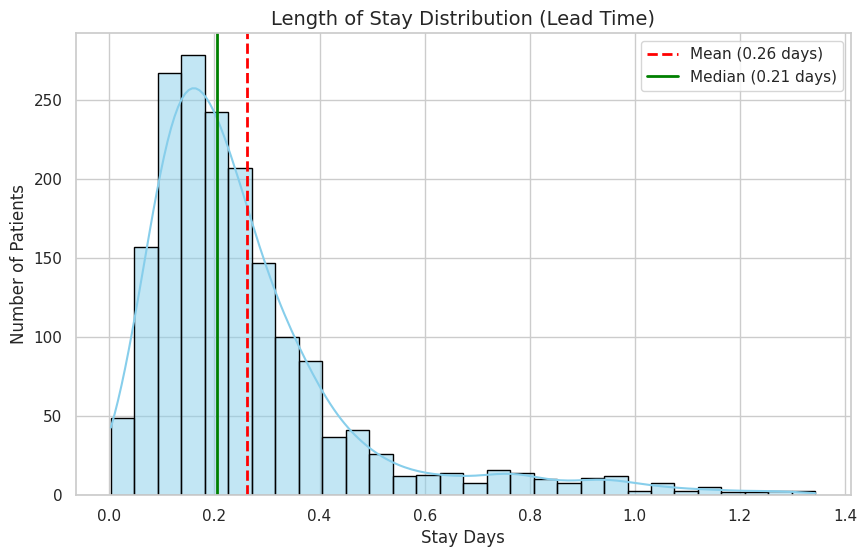

In [32]:
# Case Level dataset one row per patient
case_df = df.drop_duplicates('case:concept:name')

# Stratification by Acuity
if 'acuity' in case_df.columns:
    print("\nLEAD TIME BY ACUITY LEVEL")
    acuity_stats = case_df.groupby('acuity')['lead_time_days'].describe()
    print(acuity_stats)

    # Comparative plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=case_df, x='acuity', y='lead_time_days', palette='coolwarm')
    plt.title('Lead Time by Acuity Level')
    plt.xlabel('Acuity Level (1=Critical, 5=Non Urgent)')
    plt.ylabel('Stay Days')
    plt.show()

plt.figure(figsize=(10, 6))
# KDE True adds the smooth curve line
sns.histplot(case_df['lead_time_days'], kde=True, bins=30, color='skyblue', edgecolor='black')

# Add reference lines Theory Mean vs Median
plt.axvline(case_df['lead_time_days'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean ({case_df["lead_time_days"].mean():.2f} days)')
plt.axvline(case_df['lead_time_days'].median(), color='green', linestyle='-', linewidth=2, label=f'Median ({case_df["lead_time_days"].median():.2f} days)')

plt.title('Length of Stay Distribution (Lead Time)', fontsize=14)
plt.xlabel('Stay Days')
plt.ylabel('Number of Patients')
plt.legend()
plt.show()

Bottleneck Analysis and Visualization

/tmp/ipython-input-1063735772.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="step_duration_hours", y="concept:name", data=plot_data, order=order, showfliers=False, palette="viridis")


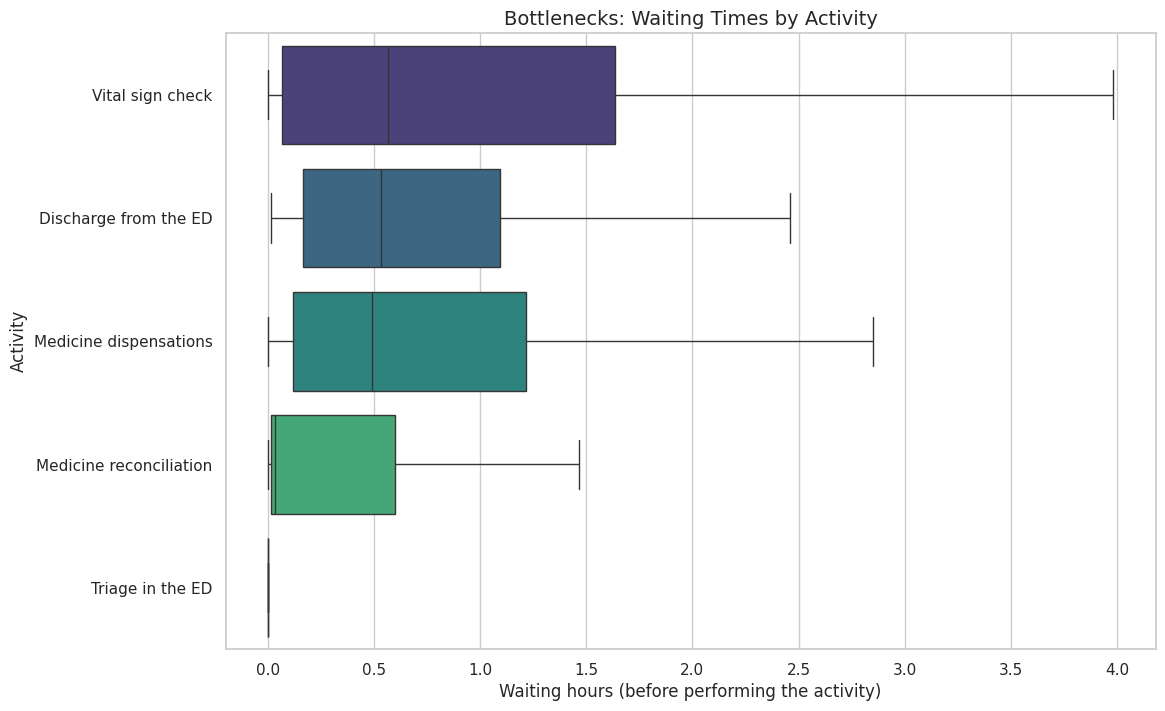


TOP 5 BOTTLENECKS (Median + Frequency)
                         Median_Hours  Occurrences
concept:name                                      
Vital sign check                 0.57         5558
Discharge from the ED            0.53         1783
Medicine dispensations           0.49         3126
Medicine reconciliation          0.03         2054
Triage in the ED                 0.00         1773


In [33]:
# Remove Enter the ED because it always has time 0
plot_data = df[df['concept:name'] != 'Enter the ED']

# Sort activities from slowest to fastest based on median
# This makes the plot readable
order = plot_data.groupby("concept:name")["step_duration_hours"].median().sort_values(ascending=False).index

plt.figure(figsize=(12, 8))
# showfliers False hides extreme points to make the plot cleaner
sns.boxplot(x="step_duration_hours", y="concept:name", data=plot_data, order=order, showfliers=False, palette="viridis")

plt.title('Bottlenecks: Waiting Times by Activity', fontsize=14)
plt.xlabel('Waiting hours (before performing the activity)')
plt.ylabel('Activity')
plt.show()

print("\nTOP 5 BOTTLENECKS (Median + Frequency)")
bottleneck_summary = plot_data.groupby('concept:name').agg({
    'step_duration_hours': ['median', 'count']
}).round(2)
bottleneck_summary.columns = ['Median_Hours', 'Occurrences']
bottleneck_summary = bottleneck_summary.sort_values('Median_Hours', ascending=False)
print(bottleneck_summary.head(5))

Arrival Rate Analysis

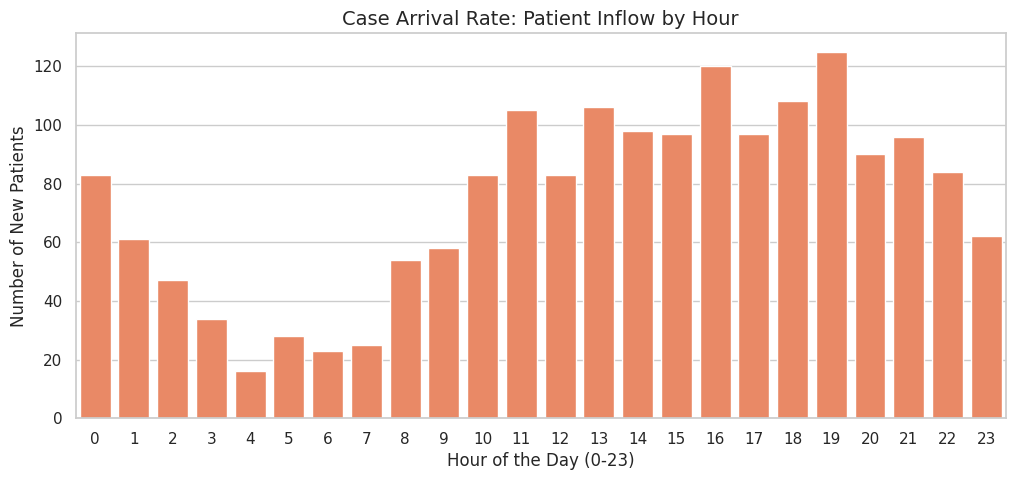

In [34]:
# Take only the first event of each case
first_events = df.sort_values('time:timestamp').groupby('case:concept:name').first()

# Count arrivals by hour 0 to 23
arrival_counts = first_events['time:timestamp'].dt.hour.value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.barplot(x=arrival_counts.index, y=arrival_counts.values, color="coral")

plt.title('Case Arrival Rate: Patient Inflow by Hour', fontsize=14)
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of New Patients')
plt.show()

Activity Frequency Visualization

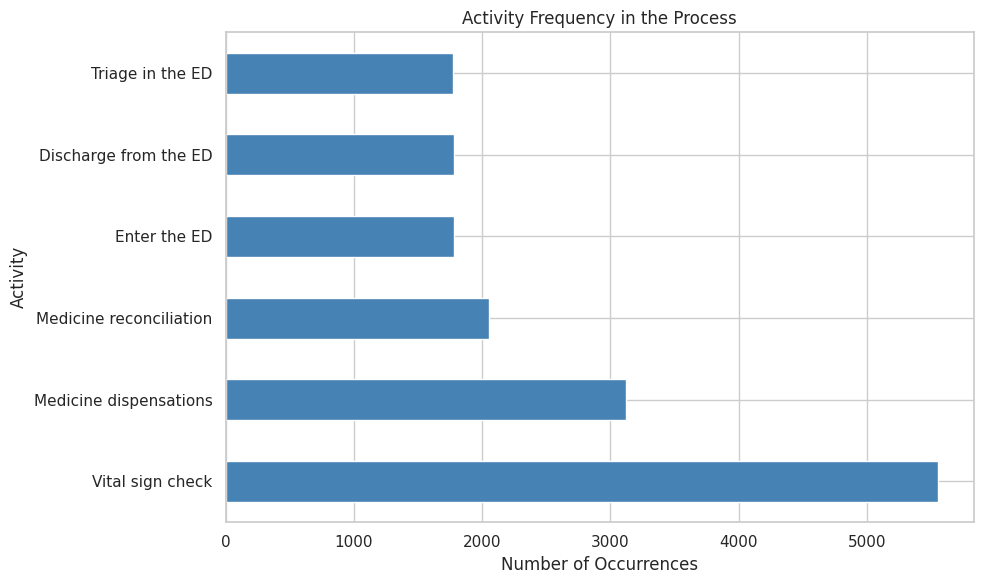

In [35]:
# Activity Frequency Analysis
activity_counts = df['concept:name'].value_counts()

plt.figure(figsize=(10, 6))
activity_counts.plot(kind='barh', color='steelblue')
plt.title('Activity Frequency in the Process')
plt.xlabel('Number of Occurrences')
plt.ylabel('Activity')
plt.tight_layout()
plt.show()

Resource Utilization and Workload Balance Analysis

In [36]:
if 'org:resource' in df.columns:
    # 1. Who does the most work? (Event volume)
    resource_counts = df['org:resource'].value_counts()

    print("Top 5 Staff by Work Volume:")
    print(resource_counts.head(5))

    # 2. Imbalance Analysis (Disparity)
    # Calculate Coefficient of Variation (CV)
    # Low CV (<0.5) is Balanced. High CV (>1) is Unbalanced.
    counts = resource_counts.values
    std_dev = counts.std()
    mean_load = counts.mean()
    cv = std_dev / mean_load

    print(f"\nBalance Metrics:")
    print(f"Mean Events per Staff: {mean_load:.1f}")
    print(f"Load Disparity (CV):  {cv:.2f}")

    if cv > 1:
        print("DIAGNOSIS: Unbalanced load. Few work a lot.")
    else:
        print("DIAGNOSIS: Well distributed load.")
else:
    print("Column 'org:resource' not found.")

Top 5 Staff by Work Volume:
org:resource
Unknown    10897
1.0         2913
2.0          795
3.0          448
4.0          319
Name: count, dtype: int64

Balance Metrics:
Mean Events per Staff: 893.2
Load Disparity (CV):  2.82
DIAGNOSIS: Unbalanced load. Few work a lot.


Inter-Arrival Time and Burstiness Analysis

In [37]:
# Find the arrival time for each case
case_starts = df.groupby('case:concept:name')['time:timestamp'].min().sort_values()

# Calculate difference between consecutive arrivals
iat = case_starts.diff().dt.total_seconds() / 60 # In Minutes

# Statistics
mean_iat = iat.mean()
median_iat = iat.median()

print(f"Mean IAT:   {mean_iat:.2f} minutes")
print(f"Median IAT: {median_iat:.2f} minutes")

# Burstiness analysis
# If mean is much higher than median it implies long calm periods
# interrupted by sudden bursts of arrivals
if mean_iat > (median_iat * 1.5):
    print("Burstiness detected. Arrivals occur in sudden waves.")
else:
    print("Regular arrival flow.")

Mean IAT:   286.67 minutes
Median IAT: 186.00 minutes
Burstiness detected. Arrivals occur in sudden waves.


Little's Law Verification

In [38]:
# Formula: WIP = CAR * LT
# Calculate average parameters in days
# Total log duration in days
log_days = (df['time:timestamp'].max() - df['time:timestamp'].min()).total_seconds() / 86400

# CAR (Lambda): Total patients / Total days
lambda_car = df['case:concept:name'].nunique() / log_days

# Lead Time (W): Already calculated, taking the mean
w_lead_time = df.drop_duplicates('case:concept:name')['lead_time_days'].mean()

# Real WIP (L): Average daily present patients
l_wip_real = df.set_index('time:timestamp').resample('D')['case:concept:name'].nunique().mean()

# Calculate Theoretical WIP
l_wip_theoretical = lambda_car * w_lead_time

print(f"Measured Data:")
print(f"CAR (Arrivals/Day): {lambda_car:.2f}")
print(f"Mean Lead Time:       {w_lead_time:.2f} days")
print(f"Real WIP (Measured): {l_wip_real:.2f} patients")

print(f"\nVerification:")
print(f"Theoretical WIP (CAR*LT): {l_wip_theoretical:.2f} patients")

# Outcome
diff_percent = abs(l_wip_real - l_wip_theoretical) / l_wip_real
if diff_percent < 0.2:
    print(f"Little's Law verified (Gap {diff_percent:.1%}). System is STABLE.")
else:
    print(f"Significant gap ({diff_percent:.1%}). System is UNSTABLE.")

Measured Data:
CAR (Arrivals/Day): 5.02
Mean Lead Time:       0.26 days
Real WIP (Measured): 6.47 patients

Verification:
Theoretical WIP (CAR*LT): 1.32 patients
Significant gap (79.6%). System is UNSTABLE.


Advanced Visualization of Stability and Burstiness

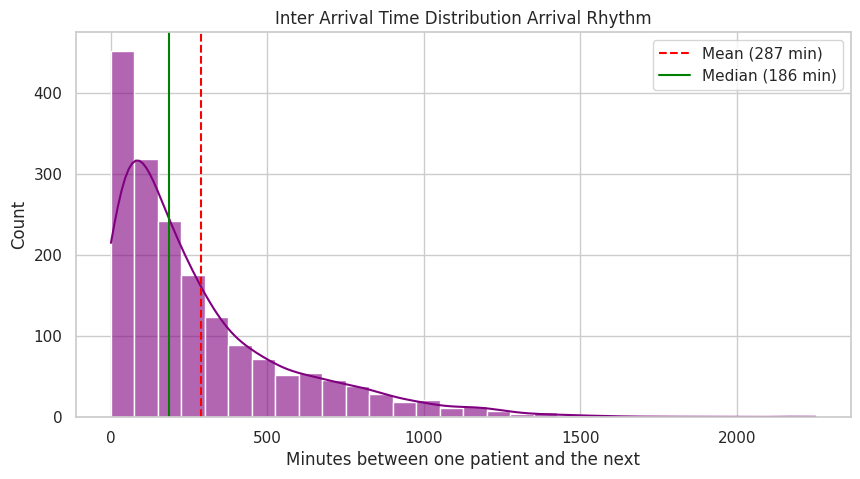

[IAT CHART] If the Median is much lower than the Mean arrivals are irregular Burstiness.


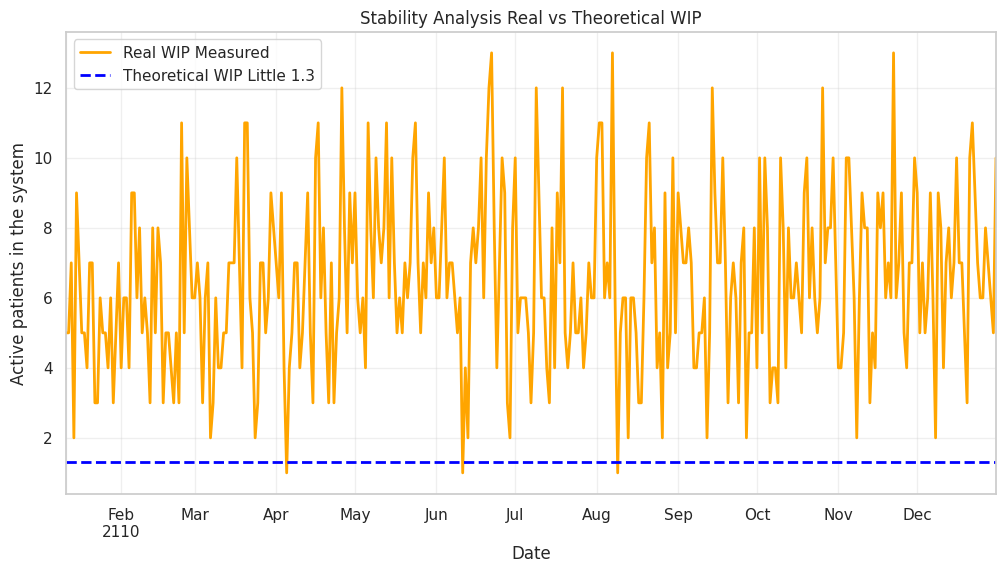

[WIP CHART] The distance between the Orange line Real and the Blue one Theory visually shows inefficiency.


In [39]:
# IAT Distribution Burstiness proof
# If there are many bars on the left short times and a long tail
# confirms that patients arrive in bursts
plt.figure(figsize=(10, 5))
sns.histplot(iat, kde=True, bins=30, color='purple', alpha=0.6)
plt.axvline(iat.mean(), color='red', linestyle='--', label=f'Mean ({iat.mean():.0f} min)')
plt.axvline(iat.median(), color='green', linestyle='-', label=f'Median ({iat.median():.0f} min)')
plt.title('Inter Arrival Time Distribution Arrival Rhythm')
plt.xlabel('Minutes between one patient and the next')
plt.legend()
plt.show()
print("[IAT CHART] If the Median is much lower than the Mean arrivals are irregular Burstiness.")


# WIP EVOLUTION Instability proof
# Little Law failed 79 percent gap Lets see WHY
# Plot how many patients are there every day If the chart always rises the system is exploding
plt.figure(figsize=(12, 6))
daily_wip = df.set_index('time:timestamp').resample('D')['case:concept:name'].nunique()
daily_wip.plot(kind='line', color='orange', linewidth=2, label='Real WIP Measured')

# Add the Theoretical WIP line what SHOULD be there if it were efficient
plt.axhline(y=l_wip_theoretical, color='blue', linestyle='--', linewidth=2, label=f'Theoretical WIP Little {l_wip_theoretical:.1f}')

plt.title('Stability Analysis Real vs Theoretical WIP')
plt.ylabel('Active patients in the system')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print("[WIP CHART] The distance between the Orange line Real and the Blue one Theory visually shows inefficiency.")

Advanced Variant Analysis and Performance Comparison

Top 5 Variants:
  Variant_Label  count  Percentage  Cumulative_Perc
0         Var 1     76    4.262479         4.262479
1         Var 2     60    3.365115         7.627594
2         Var 3     49    2.748177        10.375771
3         Var 4     46    2.579921        12.955693
4         Var 5     33    1.850813        14.806506


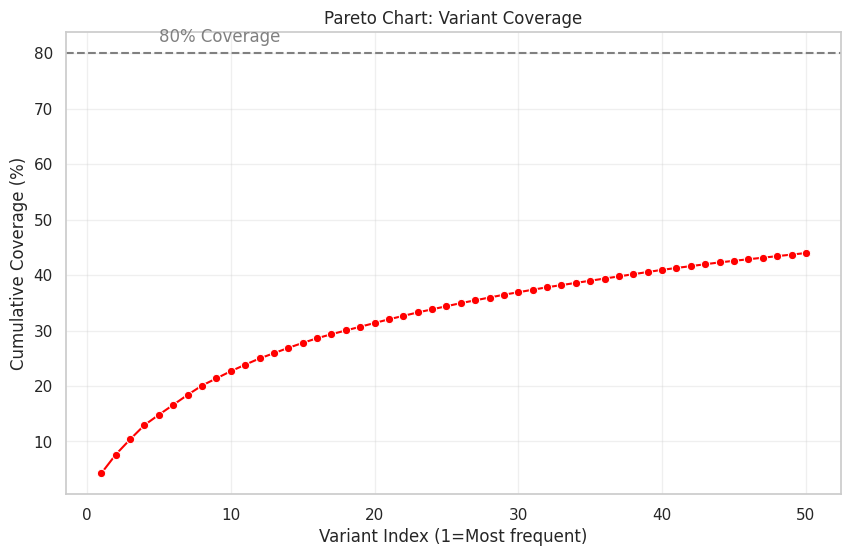

/tmp/ipython-input-1462383092.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=top_variants_data, x='Variant_Label', y='lead_time_days',


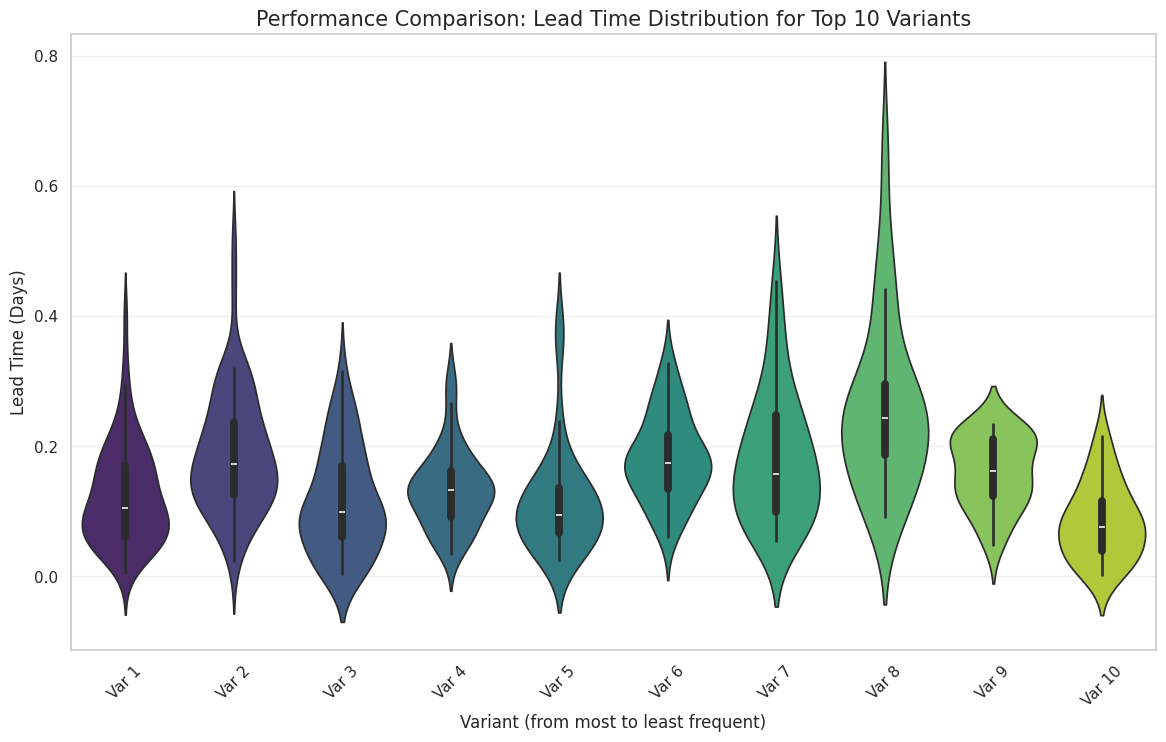


VIOLIN PLOT INTERPRETATION:
- If violins are short and wide the process is stable and fast.
- If violins are tall and narrow there is high variability unpredictable.
- If Var 1 is very different from Var 2 exceptions cost time.


In [40]:
# Case to Variant Mapping
# PM4Py returns variants as a dictionary
# We need to invert this map to know which variant each case belongs to
variants_dict = pm4py.get_variants(df)
case_to_variant_map = []

# Iterate to create a flat list
# PM4Py get_variants sometimes returns complex objects so we handle them by converting to string
sorted_variants = sorted(variants_dict.items(), key=lambda x: len(x[1]) if isinstance(x[1], list) else x[1], reverse=True)

for idx, (variant_tuple, cases) in enumerate(sorted_variants):
    variant_name = f"Variant {idx + 1}"
    # If cases is a list of traces or IDs
    if isinstance(cases, list):
        for case in cases:
            # Extract case ID depending on PM4Py version try casting to string or attribute
            try:
                c_id = case.attributes['concept:name']
            except:
                c_id = str(case) # Fallback for string lists
            case_to_variant_map.append({'case:concept:name': c_id, 'Variant_Index': idx + 1, 'Variant_Label': variant_name})
    # If cases is just a number this method does not work for 1 to 1 mapping
    # but standard PM4Py on dataframes usually allows recovering the variant per case
    # Robust alternative method on DataFrames follows
    pass

# ROBUST ALTERNATIVE METHOD Works always with DataFrames
# Group by case and create the variant string
case_variant_df = df.sort_values(['case:concept:name', 'time:timestamp']).groupby('case:concept:name')['concept:name'].apply(tuple).reset_index()
case_variant_df.rename(columns={'concept:name': 'variant_tuple'}, inplace=True)

# Calculate frequency and rank
variant_stats = case_variant_df['variant_tuple'].value_counts().reset_index()
variant_stats.columns = ['variant_tuple', 'count']
variant_stats['Variant_Index'] = variant_stats.index + 1
variant_stats['Variant_Label'] = "Var " + variant_stats['Variant_Index'].astype(str)
variant_stats['Percentage'] = (variant_stats['count'] / variant_stats['count'].sum()) * 100
variant_stats['Cumulative_Perc'] = variant_stats['Percentage'].cumsum()

# Merge everything to the main case dataset
case_variant_info = case_variant_df.merge(variant_stats, on='variant_tuple')

# Now merge this info to the case_df dataframe one row per patient with lead time
# Ensure case_df exists from section 4B
if 'lead_time_days' not in df.columns:
    # Quick recalculation if missing
    df['case_start'] = df.groupby('case:concept:name')['time:timestamp'].transform('min')
    df['case_end'] = df.groupby('case:concept:name')['time:timestamp'].transform('max')
    df['lead_time_days'] = (df['case_end'] - df['case_start']).dt.total_seconds() / (24 * 3600)

case_df_variants = df.drop_duplicates('case:concept:name')[['case:concept:name', 'lead_time_days']].merge(
    case_variant_info[['case:concept:name', 'Variant_Index', 'Variant_Label', 'Percentage']],
    on='case:concept:name'
)

print("Top 5 Variants:")
print(variant_stats.head(5)[['Variant_Label', 'count', 'Percentage', 'Cumulative_Perc']])

# PARETO PLOT Power Law behavior
plt.figure(figsize=(10, 6))
# Cumulative line
ax1 = sns.lineplot(data=variant_stats.head(50), x='Variant_Index', y='Cumulative_Perc', color='red', marker='o')
plt.axhline(80, color='grey', linestyle='--')
plt.text(5, 82, "80% Coverage", color='grey')
plt.title('Pareto Chart: Variant Coverage')
plt.xlabel('Variant Index (1=Most frequent)')
plt.ylabel('Cumulative Coverage (%)')
plt.grid(True, alpha=0.3)
plt.show()

# VIOLIN PLOT Lead Time vs Variant
# Take only the Top 10 variants to avoid overcrowding the plot
top_k = 10
top_variants_data = case_df_variants[case_df_variants['Variant_Index'] <= top_k]

plt.figure(figsize=(14, 8))
sns.violinplot(data=top_variants_data, x='Variant_Label', y='lead_time_days',
               order=[f"Var {i}" for i in range(1, top_k+1)], palette="viridis")

# Add medians as white dots for clarity
medians = top_variants_data.groupby('Variant_Label')['lead_time_days'].median()
# Optional add text labels for medians

plt.title(f'Performance Comparison: Lead Time Distribution for Top {top_k} Variants', fontsize=15)
plt.xlabel('Variant (from most to least frequent)')
plt.ylabel('Lead Time (Days)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\nVIOLIN PLOT INTERPRETATION:")
print("- If violins are short and wide the process is stable and fast.")
print("- If violins are tall and narrow there is high variability unpredictable.")
print("- If Var 1 is very different from Var 2 exceptions cost time.")

Executive Summary and Key Performance Indicators

In [41]:
# Key Metrics
print(f"Analyzed cases: {df['case:concept:name'].nunique()}")
print(f"Median Lead Time: {case_df['lead_time_days'].median():.1f} days")
print(f"Main Bottleneck: {plot_data.groupby('concept:name')['step_duration_hours'].median().idxmax()}")

if 'org:resource' in df.columns:
    print(f"Staff workload CV: {cv:.2f} {'UNBALANCED' if cv > 1 else 'BALANCED'}")

print(f"Mean IAT: {mean_iat:.1f} min {'BURSTINESS' if mean_iat > median_iat * 1.5 else 'REGULAR'}")
print(f"Little's Law: {'VERIFIED' if diff_percent < 0.2 else 'UNSTABLE SYSTEM'} (Gap: {diff_percent:.1%})")

if 'acuity' in case_df.columns:
    critical_lt = case_df[case_df['acuity'] == 1]['lead_time_days'].median()
    routine_lt = case_df[case_df['acuity'] == 5]['lead_time_days'].median()
    print(f"Lead Time Acuity 1 (Critical): {critical_lt:.1f} days")
    print(f"Lead Time Acuity 5 (Routine): {routine_lt:.1f} days")

Analyzed cases: 1783
Median Lead Time: 0.2 days
Main Bottleneck: Vital sign check
Staff workload CV: 2.82 UNBALANCED
Mean IAT: 286.7 min BURSTINESS
Little's Law: UNSTABLE SYSTEM (Gap: 79.6%)
Lead Time Acuity 1 (Critical): 0.2 days
Lead Time Acuity 5 (Routine): 0.1 days


# **Process disovery and Performance checking**

Statistical Hypothesis Testing (Chi-Square & ANOVA)

In [42]:
# Aggregate data by Case (Patient)
# Acuity and Disposition are case attributes (take the first one)
# Heartrate is numeric (take the case mean)
stats_df = df.groupby('case:concept:name').agg({
    'acuity': 'first',
    'disposition': 'first',
    'heartrate': 'mean'
}).reset_index()

# CHI-SQUARE (Acuity vs Disposition)
# Objective: Understand if severity (Acuity) influences outcome (Disposition)
print("\n[TEST 1] Chi-Square: Acuity vs Disposition")
chi_data = stats_df.dropna(subset=['acuity', 'disposition'])
contingency = pd.crosstab(chi_data['acuity'], chi_data['disposition'])
chi2, p_val, dof, ex = stats.chi2_contingency(contingency)

print(f"P-value: {p_val:.4e}")
if p_val < 0.05:
    print("-> RESULT: Significant Relationship. (Outcome depends on severity)")
else:
    print("-> RESULT: No significant relationship.")

# ANOVA (Heartrate vs Acuity)
# Objective: Understand if mean heart rate changes based on severity
print("\nANOVA: Heartrate by Acuity Level")
anova_data = stats_df.dropna(subset=['heartrate', 'acuity'])
groups = [g['heartrate'].values for n, g in anova_data.groupby('acuity')]
f_stat, p_val_anova = stats.f_oneway(*groups)

print(f"Mean Heart Rate by Acuity:\n{anova_data.groupby('acuity')['heartrate'].mean()}")
print(f"P-value: {p_val_anova:.4e}")
if p_val_anova < 0.05:
    print("-> RESULT: Significant Difference. (More severe patients have different heart rates)")
else:
    print("-> RESULT: No significant difference.")


[TEST 1] Chi-Square: Acuity vs Disposition
P-value: 2.7528e-61
-> RESULT: Significant Relationship. (Outcome depends on severity)

ANOVA: Heartrate by Acuity Level
Mean Heart Rate by Acuity:
acuity
1.0    88.277960
2.0    82.830116
3.0    81.779339
4.0    80.347887
5.0    84.071429
Name: heartrate, dtype: float64
P-value: 1.1697e-04
-> RESULT: Significant Difference. (More severe patients have different heart rates)


Process Discovery Algorithms (Inductive, Heuristic, DFG)


Inductive Miner (Structure)


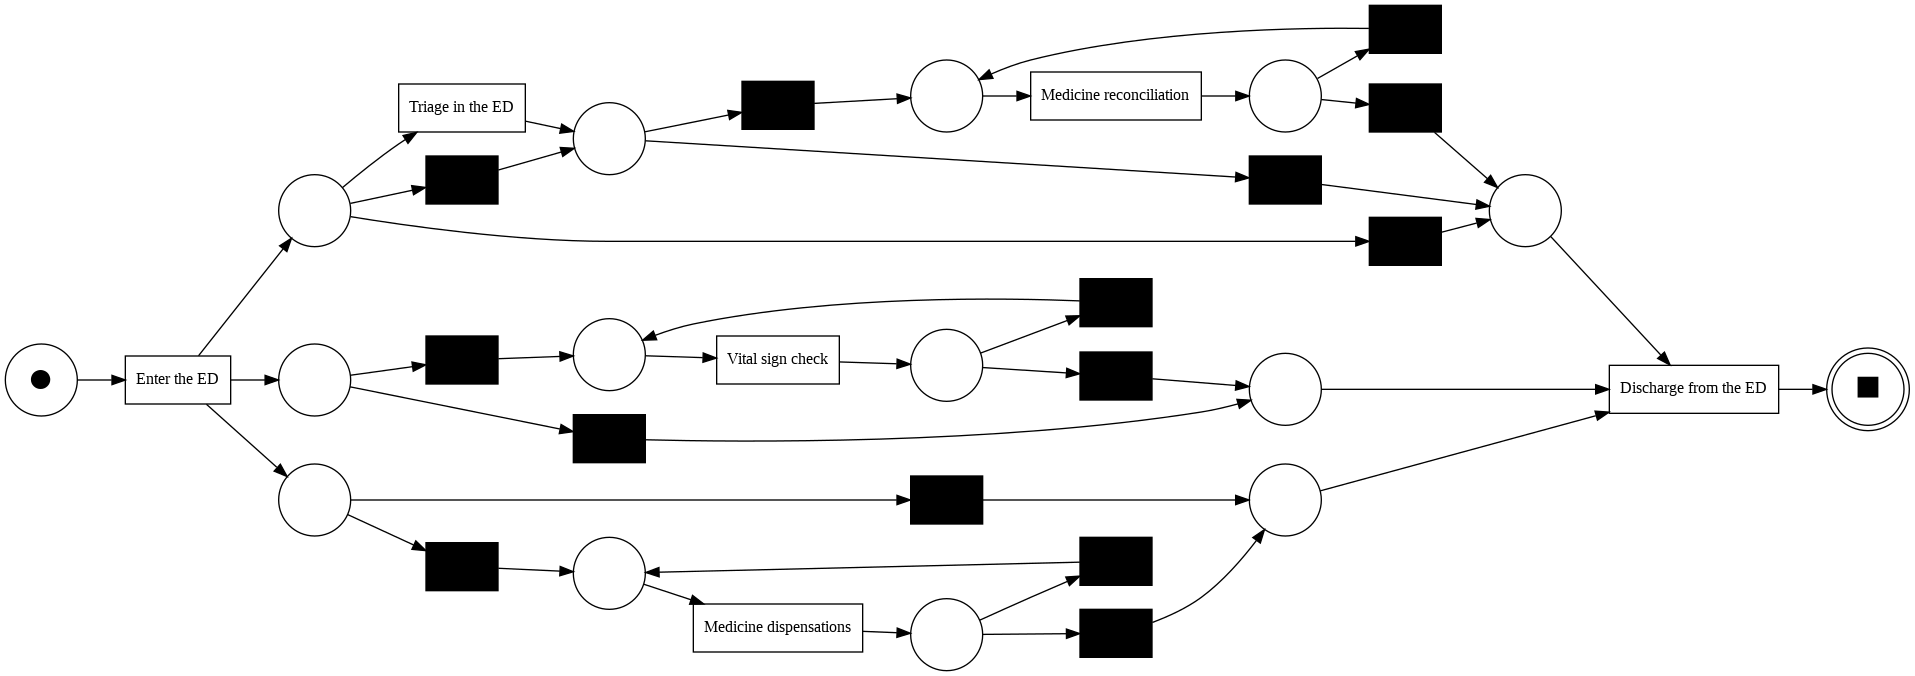

-> Inductive Miner visualized.

Heuristic Miner (Petri Net)


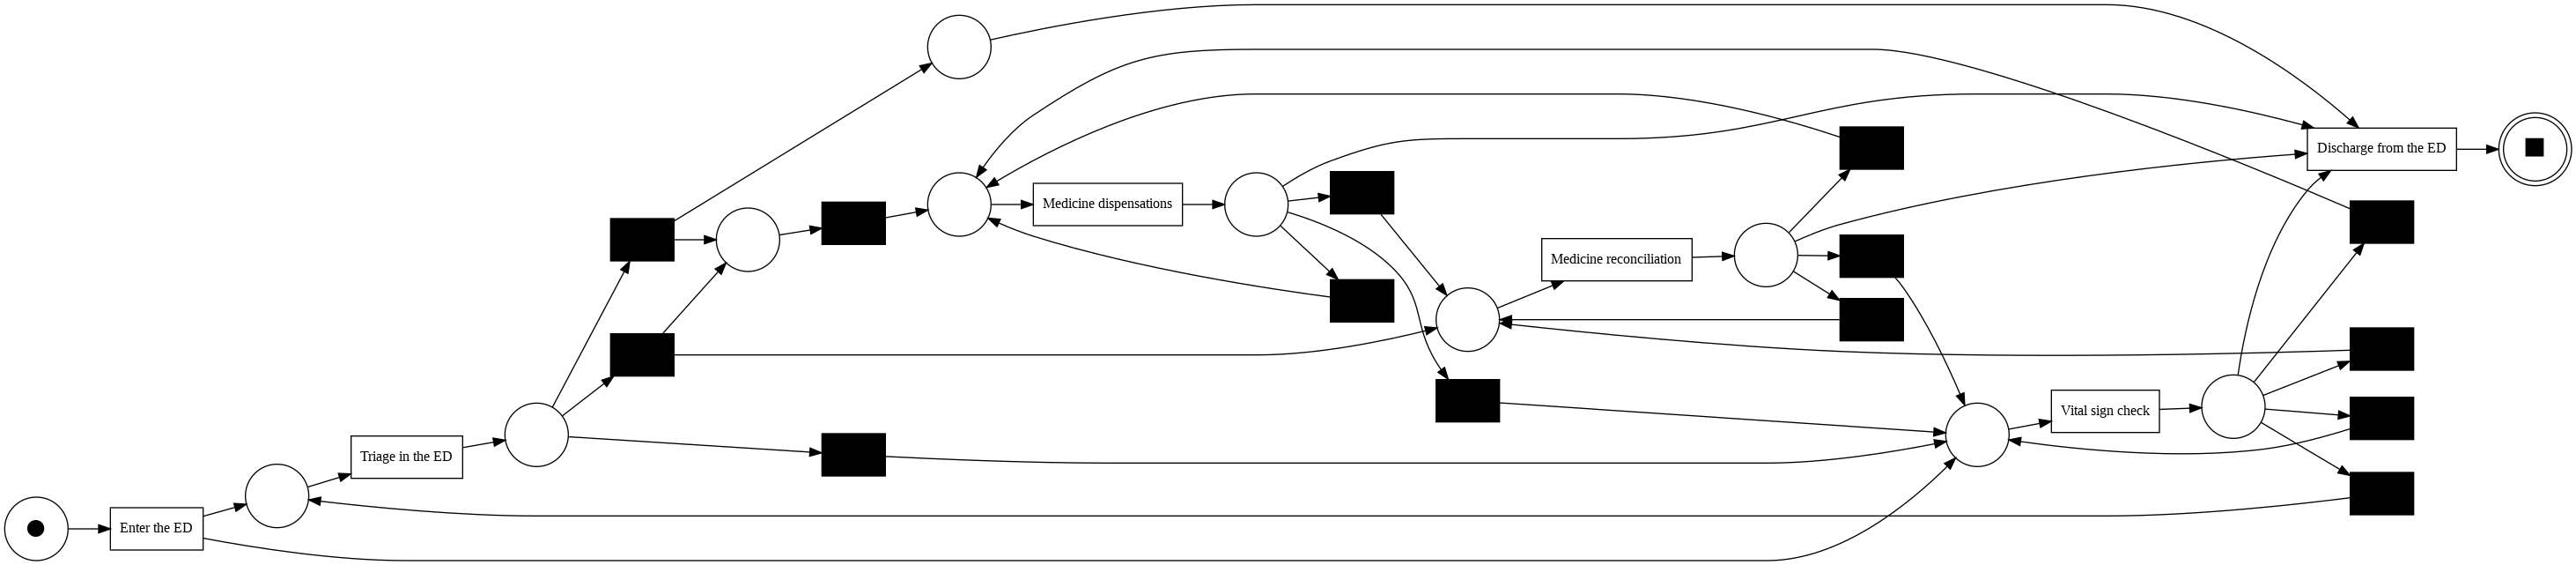

-> Heuristic Miner Petri Net visualized.

Heuristic Miner (Frequencies)


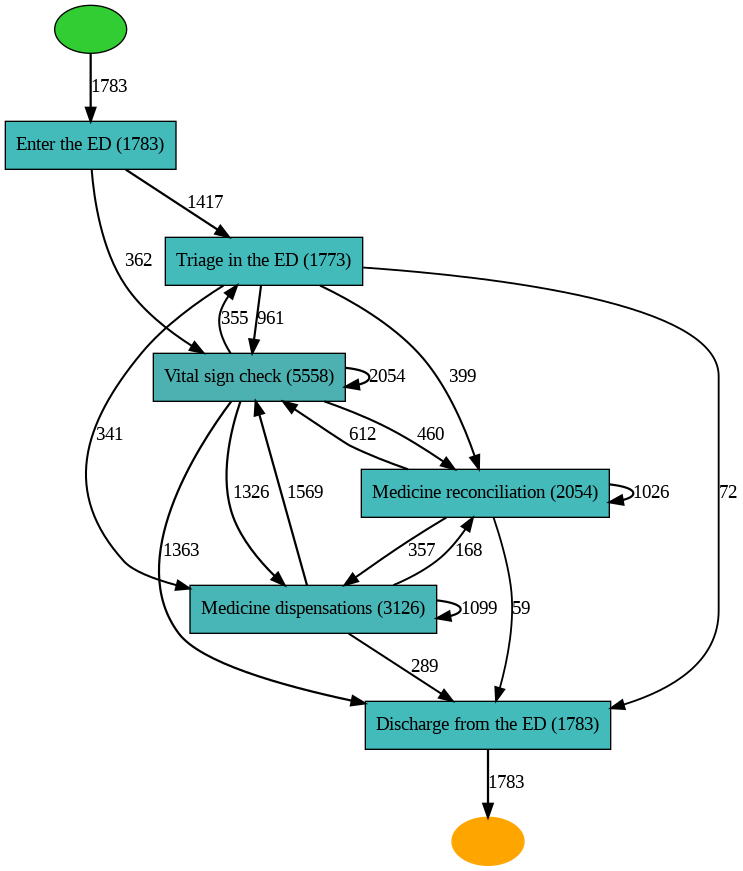

-> Heuristic Miner visualized.

DFG (Flow Visualization)


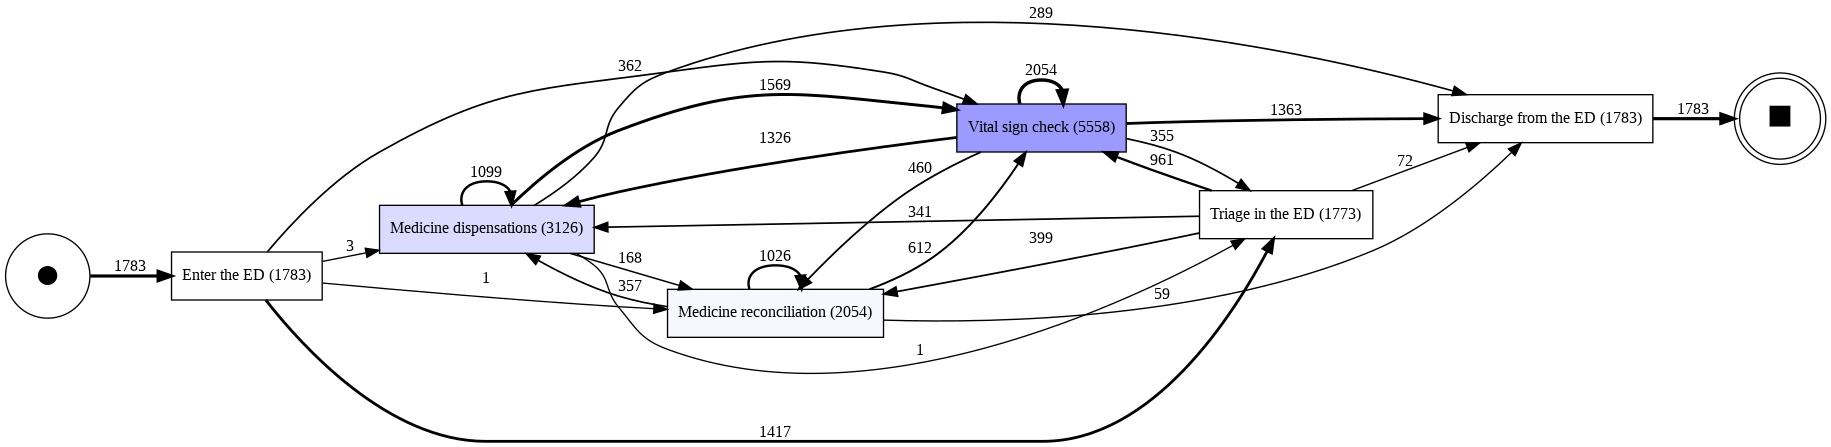

-> DFG visualized correctly.
Discovery phase complete.


In [43]:
# We use the log converter only if strictly necessary but modern PM4Py often uses DFs directly
# However for safety with older versions or exams convert to Event Log
log = log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)

# Inductive Miner Petri Net
# This algorithm guarantees a sound model without deadlocks
print("\nInductive Miner (Structure)")
net_ind, im_ind, fm_ind = pm4py.discover_petri_net_inductive(
    log,
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp'
)

pm4py.view_petri_net(net_ind, im_ind, fm_ind, format='png')
print("-> Inductive Miner visualized.")

# Heuristic Miner Petri Net
# Heuristic Miner that directly returns a Petri Net
print("\nHeuristic Miner (Petri Net)")

net_heu, im_heu, fm_heu = pm4py.discover_petri_net_heuristics(
    log,
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp'
)

pm4py.view_petri_net(net_heu, im_heu, fm_heu, format='png')
print("-> Heuristic Miner Petri Net visualized.")

# Heuristic Miner Heuristic Net
# Better for handling noise and frequencies
print("\nHeuristic Miner (Frequencies)")

heu_net = pm4py.discover_heuristics_net(
    log,
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp'
)

pm4py.view_heuristics_net(heu_net, format='png')
print("-> Heuristic Miner visualized.")


# Directly Follows Graph DFG visualization
print("\nDFG (Flow Visualization)")

dfg, start_activities, end_activities = pm4py.discover_dfg(df)

# Pass all 3 required arguments to the view function
pm4py.view_dfg(dfg, start_activities, end_activities, format='png')
print("-> DFG visualized correctly.")

print("Discovery phase complete.")

Automatic Variant Optimization and Model Selection

Starting optimization for K from 1 to 15...


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=1: Fitness=0.677, Precision=1.000 => F1=0.807


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=2: Fitness=0.969, Precision=0.999 => F1=0.984


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=3: Fitness=0.981, Precision=1.000 => F1=0.990


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=4: Fitness=0.875, Precision=0.999 => F1=0.933


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=5: Fitness=0.812, Precision=0.999 => F1=0.896


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=6: Fitness=0.864, Precision=0.982 => F1=0.919


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=7: Fitness=0.844, Precision=0.989 => F1=0.910


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=8: Fitness=0.844, Precision=0.989 => F1=0.910


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=9: Fitness=0.864, Precision=0.987 => F1=0.921


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=10: Fitness=0.864, Precision=0.987 => F1=0.921


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=11: Fitness=0.903, Precision=0.982 => F1=0.941


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=12: Fitness=0.903, Precision=0.982 => F1=0.941


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=13: Fitness=0.903, Precision=0.982 => F1=0.941


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=14: Fitness=0.903, Precision=0.982 => F1=0.941


replaying log with TBR, completed traces ::   0%|          | 0/862 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/3554 [00:00<?, ?it/s]

-> K=15: Fitness=0.903, Precision=0.982 => F1=0.941

Optimal number of variants is K = 3


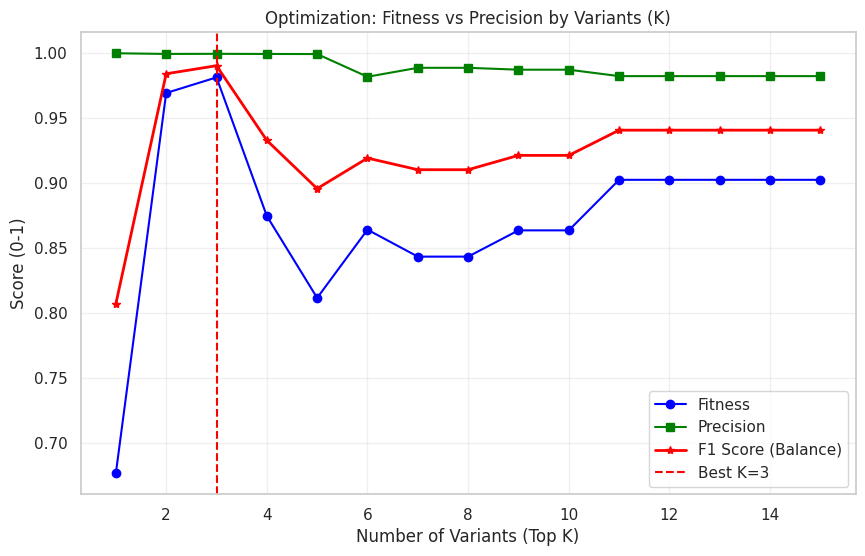

Creating optimized dataset with Top 3 variants...
Generating Petri Net based on 3 most frequent variants...


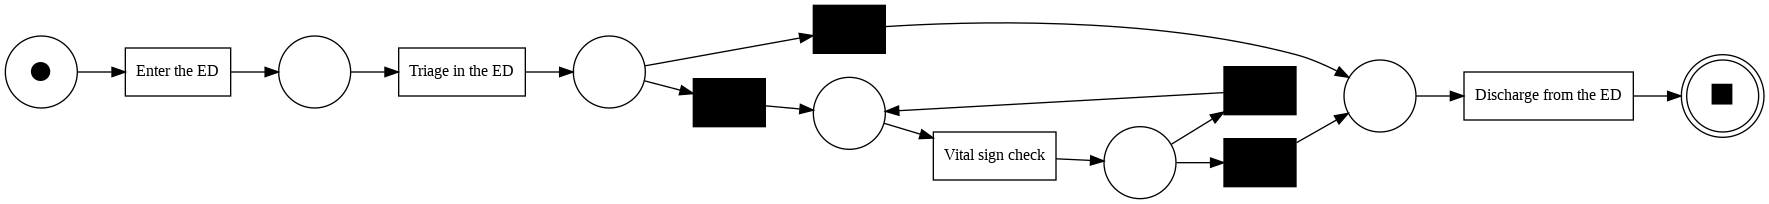

In [44]:
def find_best_k_variants(dataframe, k_min=1, k_max=15, step=1):
    """
    Tests models keeping Top-K variants.
    Returns K that maximizes F1 Score (Harmonic mean of Fitness and Precision).
    """
    print(f"Starting optimization for K from {k_min} to {k_max}...")

    # Convert main DF to Event Log once for validation
    # Use FULL log to calculate fitness to see how reduced model explains total reality
    full_log = log_converter.apply(dataframe, variant=log_converter.Variants.TO_EVENT_LOG)

    results = []
    best_f1 = -1
    best_k = k_min

    # Loop over various K values
    for k in range(k_min, k_max + 1, step):
        # Filter dataset keeping only top K variants
        filtered_log = pm4py.filter_variants_top_k(full_log, k)

        # Skip if filtered log is empty or problematic
        if len(filtered_log) == 0: continue

        try:
            # Model discovery (Petri Net) on FILTERED log
            # Use Inductive Miner for speed and soundness guarantee
            net, im, fm = pm4py.discover_petri_net_inductive(filtered_log)

            # Conformance Checking on FULL log
            # Question: How well does this simplified model explain ALL original data?

            # Fitness
            fit_res = replay_fitness.apply(full_log, net, im, fm, variant=replay_fitness.Variants.TOKEN_BASED)
            fitness = fit_res['log_fitness']

            # Precision
            prec_res = precision_evaluator.apply(full_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
            precision = prec_res

            # Calculate F1 Score
            if (precision + fitness) > 0:
                f1 = 2 * (precision * fitness) / (precision + fitness)
            else:
                f1 = 0

            results.append({'k': k, 'Fitness': fitness, 'Precision': precision, 'F1': f1})
            print(f"-> K={k}: Fitness={fitness:.3f}, Precision={precision:.3f} => F1={f1:.3f}")

            if f1 > best_f1:
                best_f1 = f1
                best_k = k

        except Exception as e:
            print(f"Error with K={k}: {e}")
            continue

    return best_k, pd.DataFrame(results)

# Set a reasonable range
# If many variants exist, testing top 10-20 is usually enough to find the peak
best_k, results_df = find_best_k_variants(df, k_min=1, k_max=15)

print(f"\nOptimal number of variants is K = {best_k}")

plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['Fitness'], marker='o', label='Fitness', color='blue')
plt.plot(results_df['k'], results_df['Precision'], marker='s', label='Precision', color='green')
plt.plot(results_df['k'], results_df['F1'], marker='*', label='F1 Score (Balance)', color='red', linewidth=2)

plt.axvline(best_k, color='red', linestyle='--', label=f'Best K={best_k}')
plt.title('Optimization: Fitness vs Precision by Variants (K)')
plt.xlabel('Number of Variants (Top K)')
plt.ylabel('Score (0-1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Overwrite df or create new one with only optimal variants
# NOTE: Work on a copy for discovery safety
print(f"Creating optimized dataset with Top {best_k} variants...")
df_optimized = pm4py.filter_variants_top_k(df, best_k)

# Update variables for next block
log = log_converter.apply(df_optimized, variant=log_converter.Variants.TO_EVENT_LOG)
df = df_optimized # Use this for subsequent Discovery

print(f"Generating Petri Net based on {best_k} most frequent variants...")
final_net, final_im, final_fm = pm4py.discover_petri_net_inductive(log)

# On-screen visualization
# This will open a window or show image if in Jupyter
pm4py.view_petri_net(final_net, final_im, final_fm)

Pattern-Based Variant Analysis and Process Comparison

Generating Binary Patterns Binary Mapping Function φ...

Pattern Distribution Data Aware Variants:
Data_Variant_Label
V(0,0,1)    63
V(0,0,0)    63
V(1,0,1)    22
V(1,0,0)    21
V(0,1,0)     8
V(1,1,1)     4
V(0,1,1)     3
V(1,1,0)     1
Name: count, dtype: int64


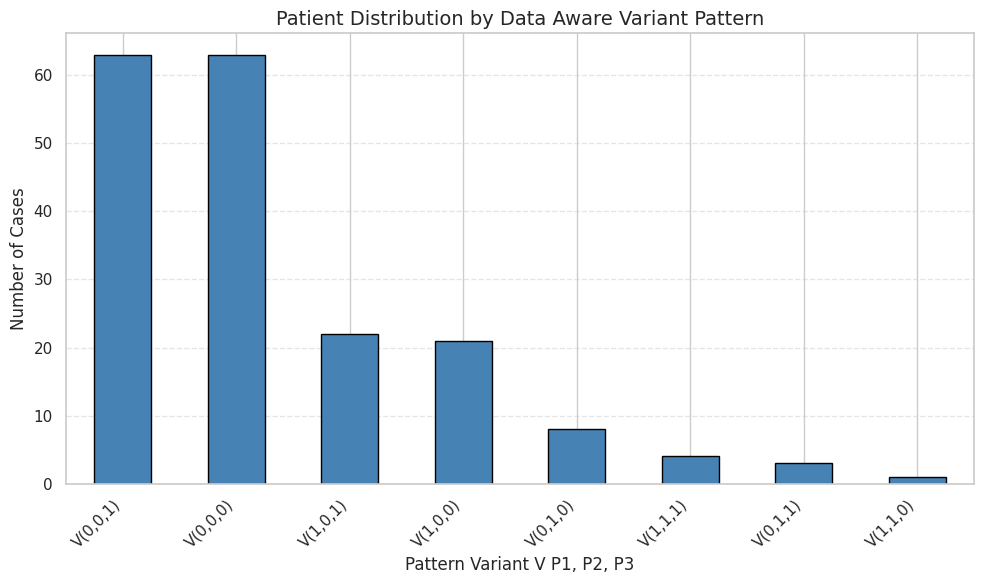


PROCESS COMPARISON
COMPLEX Group Critical Abnormal: 5 cases
SIMPLE Group Routine Normal:  126 cases


In [45]:
# Work at CASE level one row per patient
case_features = df.groupby('case:concept:name').agg({
    'acuity': 'min',              # Take max severity lower number means more severe
    'heartrate': 'mean',          # Mean vital signs
    'lead_time_days': 'first'     # Duration already calculated
}).reset_index()

print("Generating Binary Patterns Binary Mapping Function φ...")

# DEFINING PROPERTIES PREDICATES
# P1 Critical Patient Acuity 1 or 2
# P2 Abnormal Vital Signs eg Tachycardia over 100 bpm
# P3 Long Stay Above global median

median_lead_time = case_features['lead_time_days'].median()

case_features['P1_Critical'] = case_features['acuity'].apply(lambda x: 1 if x <= 2 else 0)
case_features['P2_AbnormalHR'] = case_features['heartrate'].apply(lambda x: 1 if x > 100 else 0)
case_features['P3_LongStay'] = case_features['lead_time_days'].apply(lambda x: 1 if x > median_lead_time else 0)

# VECTOR ENCODING Binary Vector
# Create a string representing the vector eg V 1,0,1
case_features['Data_Variant_Label'] = case_features.apply(
    lambda row: f"V({row['P1_Critical']},{row['P2_AbnormalHR']},{row['P3_LongStay']})", axis=1
)

# Create readable labels for the report eg Critical Normal Fast
def get_description(row):
    desc = []
    desc.append("Critical" if row['P1_Critical'] else "Routine")
    desc.append("Tachycardic" if row['P2_AbnormalHR'] else "Normal")
    desc.append("Long Stay" if row['P3_LongStay'] else "Fast")
    return " + ".join(desc)

case_features['Description'] = case_features.apply(get_description, axis=1)

# DATA AWARE VARIANT ANALYSIS
# Count how many patients fall into each pattern
variant_counts = case_features['Data_Variant_Label'].value_counts()
print("\nPattern Distribution Data Aware Variants:")
print(variant_counts)

# HISTOGRAM VISUALIZATION
plt.figure(figsize=(10, 6))
# Use a professional color eg steelblue and light grid
variant_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Patient Distribution by Data Aware Variant Pattern', fontsize=14)
plt.xlabel('Pattern Variant V P1, P2, P3', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Merge these labels to the main event dataframe
df_enriched = df.merge(case_features[['case:concept:name', 'Data_Variant_Label', 'Description']], on='case:concept:name')

# PROCESS COMPARISON COMPLEX vs SIMPLE
# Compare the two extremes to see if the process changes
# COMPLEX GROUP V 1,1,X Critical and Tachycardic
# SIMPLE GROUP  V 0,0,X Routine and Normal

group_complex = df_enriched[
    (df_enriched['Data_Variant_Label'].str.contains("V(1,1", regex=False))
]
group_simple = df_enriched[
    (df_enriched['Data_Variant_Label'].str.contains("V(0,0", regex=False))
]

print(f"\nPROCESS COMPARISON")
print(f"COMPLEX Group Critical Abnormal: {group_complex['case:concept:name'].nunique()} cases")
print(f"SIMPLE Group Routine Normal:  {group_simple['case:concept:name'].nunique()} cases")

Comparative Process Visualization (Complex vs. Simple)


Visualizing Process for COMPLEX cases (V(1,1...))
Found 5 complex cases.


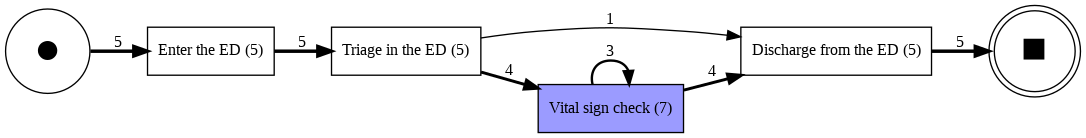

DFG 'Complex' visualized above.

Visualizing Process for SIMPLE cases (V(0,0...))
Found 126 simple cases.


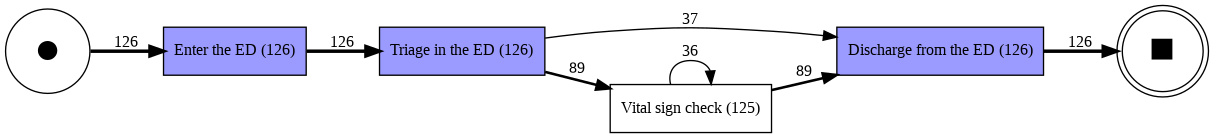

DFG 'Simple' visualized above.


In [46]:
print("\nVisualizing Process for COMPLEX cases (V(1,1...))")
df_complex = df_enriched[df_enriched['Data_Variant_Label'].str.contains("V(1,1", regex=False)]

if not df_complex.empty:
    print(f"Found {df_complex['case:concept:name'].nunique()} complex cases.")
    # Discover DFG for Complex cases
    dfg_c, start_c, end_c = pm4py.discover_dfg(df_complex)
    # Visualization
    pm4py.view_dfg(dfg_c, start_c, end_c, format='png')
    print("DFG 'Complex' visualized above.")
else:
    print("No cases found for Complex pattern.")

print("\nVisualizing Process for SIMPLE cases (V(0,0...))")
df_simple = df_enriched[df_enriched['Data_Variant_Label'].str.contains("V(0,0", regex=False)]

if not df_simple.empty:
    print(f"Found {df_simple['case:concept:name'].nunique()} simple cases.")
    # Discover DFG for Simple cases
    dfg_s, start_s, end_s = pm4py.discover_dfg(df_simple)
    # Visualization
    pm4py.view_dfg(dfg_s, start_s, end_s, format='png')
    print("DFG 'Simple' visualized above.")
else:
    print("No cases found for Simple pattern.")